In [31]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib

# loading keras and FBD experiment...
from keras import backend as K
K.set_floatx('float32')
from helpers import *
from model_conv import *
from experiment_model import *
from matplotlib import pyplot as plt
import pickle
from tqdm import tqdm
import sys
import numpy as np
from IPython.display import Image, display

# to show the model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras import Model, Input
from keras.layers import Activation

# loading resnet
from keras.applications.vgg16 import decode_predictions

from derivative_decay import line_1_bias
from scipy.optimize import curve_fit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
font = {'family' : 'STIXGeneral',
        'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)

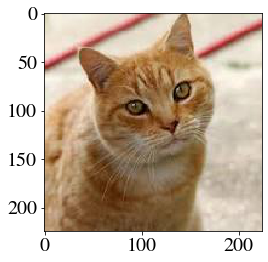

In [3]:
# loading the cat image
x = load_cat(224)

# probability of input failure
p = 0.01

In [4]:
def sum_sq(x):
    """ Sum of squares of flattened |x|_2^2 """
    return np.linalg.norm(x.flatten()) ** 2

### Creating models

In [5]:
config = {'include_top': True, 'weights': 'imagenet', 'classes': 1000}

In [6]:
ka = keras.applications

In [7]:
model_names = ['VGG16',
'VGG19',
'ResNet50',
'MobileNet',
'MobileNetV2',
'DenseNet121',
'DenseNet169',
'DenseNet201',
'NASNetMobile']

In [8]:
models = [ka.vgg16.VGG16,
          
ka.vgg19.VGG19,
ka.resnet50.ResNet50,
#ka.resnet_v2.ResNet50V2,
#ka.resnet_v2.ResNet101V2,
#ka.resnet_v2.ResNet152V2,
#ka.resnext.ResNeXt50,
#ka.resnext.ResNeXt101,
ka.mobilenet.MobileNet,
ka.mobilenet_v2.MobileNetV2,
ka.densenet.DenseNet121,
ka.densenet.DenseNet169,
ka.densenet.DenseNet201,
ka.nasnet.NASNetMobile]

In [9]:
def get_model(idx):
    """ Get a model from models """
    
    assert idx >= 0 and idx < len(models), "Wrong index"
    return models[idx](**config)

### Fault tolerances for input failure

In [10]:
### ONLY crashes at input?
input_only = True

In [11]:
def fault_tolerance(model, x, p, repetitions = 10000, do_print = False):
    """ Calculate fault tolerance of a model on input x with input failure probability p """
    # obtaining experiment from a model
    if input_only:
        #print('Running for input only')
        exp = ModelInputCrashExperiment(model, p = p)
    else:
        #print('Running for full network')
        if not no_branches(model):
            print("Model is not allowed to have skip-connections, returning 0,0")
            return 0, 0
        exp = ModelCrashExperiment(model, p = p)
    
    if do_print:
        # crashing prediction
        print(decode_predictions(exp.model_crashing.predict(x), top=3)[0])
        
        # correct prediction
        print(decode_predictions(exp.model_correct.predict(x), top=3)[0])
    
    # get experimental error
    exp_data = experiment_mean_std(exp, x, repetitions = repetitions)
        
    return sum_sq(exp_data['mean']), sum_sq(exp_data['std'] ** 2)

In [12]:
def get_fts(do_print = False):
    """ Get fault tolerance for all models """
    fts = []
    for i in range(len(models)):
        ft = fault_tolerance(get_model(i), x, p, do_print = do_print, repetitions = 500)
        #print(ft)
        fts += [ft]
        K.clear_session()
    return fts

In [13]:
def nets_info():
    """ Obtain info for networks from fault_tolerances global array """
    for net in range(len(models)):
        n = model_names[net]
        L = len(fault_tolerances)
        V = list(zip(*[x[net] for x in fault_tolerances]))
        m_mean, m_std = np.mean(V, axis = 1)
        s_mean, s_std = np.std(V, axis = 1) / L ** 0.5
        yield m_mean, s_mean, m_std, s_std

In [14]:
# repeating multiple times
fault_tolerances = [get_fts() for _ in range(5)]
pickle_w(fault_tolerances, 'ConvNetTest-ft-1')

In [15]:
fault_tolerances = pickle_r('ConvNetTest-ft-1')

In [16]:
m_means, s_means, m_stds, s_stds = zip(*nets_info())

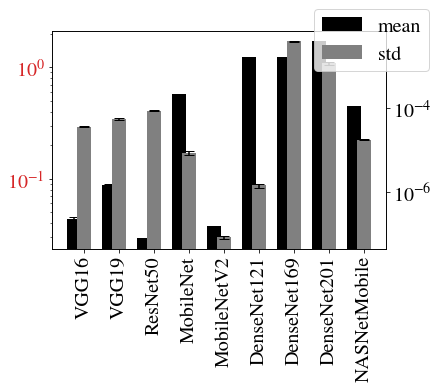

In [17]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

eps = 0.3
xs = np.arange(len(models))
ax1.bar(xs, m_means, width = 0.4, tick_label = model_names, yerr = s_means,
        error_kw = {'capsize': 5}, color = 'black', label = 'mean')
ax2.bar(xs + eps, m_stds, width = 0.4, tick_label = model_names, yerr = s_stds,
        error_kw = {'capsize': 5}, color = 'gray', label = 'std')
ax1.tick_params(axis = 'x', rotation=90)
ax1.set_yscale('log')
ax2.set_yscale('log')
plt.figlegend()
#plt.bar([1 + 0.5,2 + 0.5,3 + 0.5], [4,5,6], width = 0.4)

### Which networks have skip-connections?

In [18]:
def no_branches(model):
    """ Check if a model has no skip-connections """
    for layer in model.layers:
        if type(layer.input) == tf.Tensor:
            pass
        elif type(layer.input) == list and len(layer.input) > 1:
            #print(layer.input)
            return False
        else:
            raise NotImplemented()
    return True

In [143]:
print('No skip connections?')
for i in range(len(models)):
    print(model_names[i], no_branches(get_model(i)))
    K.clear_session()

No skip connections?
VGG16 True
VGG19 True
ResNet50 False
MobileNet True
MobileNetV2 False
DenseNet121 False
DenseNet169 False
DenseNet201 False
NASNetMobile False


Test of ModelCrashExperiment

In [336]:
K.clear_session()
model = get_model(0)
exp = ModelCrashExperiment(model, p = 0.1)

In [342]:
decode_predictions(exp.predict_correct(x))

[[('n02124075', 'Egyptian_cat', 0.47154376),
  ('n02123045', 'tabby', 0.32966527),
  ('n02127052', 'lynx', 0.12501603),
  ('n02123159', 'tiger_cat', 0.03675107),
  ('n03958227', 'plastic_bag', 0.022561021)]]

In [352]:
decode_predictions(exp.predict_crashing(x, repetitions = 1).reshape(1, 1000))

[[('n02123045', 'tabby', 0.033325262),
  ('n02124075', 'Egyptian_cat', 0.029804422),
  ('n02125311', 'cougar', 0.019169474),
  ('n02114855', 'coyote', 0.016924974),
  ('n04589890', 'window_screen', 0.016339969)]]

### Running experiments for full network crash w.p. p

In [19]:
### ONLY crashes at input?
input_only = False

In [20]:
# repeating multiple times
fault_tolerances = [get_fts() for _ in range(5)]
pickle_w(fault_tolerances, 'ConvNetTest-ft-2')

Model is not allowed to have skip-connections, returning 0,0
Model is not allowed to have skip-connections, returning 0,0
Model is not allowed to have skip-connections, returning 0,0
Model is not allowed to have skip-connections, returning 0,0
Model is not allowed to have skip-connections, returning 0,0
Model is not allowed to have skip-connections, returning 0,0
Model is not allowed to have skip-connections, returning 0,0
Model is not allowed to have skip-connections, returning 0,0
Model is not allowed to have skip-connections, returning 0,0
Model is not allowed to have skip-connections, returning 0,0
Model is not allowed to have skip-connections, returning 0,0
Model is not allowed to have skip-connections, returning 0,0
Model is not allowed to have skip-connections, returning 0,0
Model is not allowed to have skip-connections, returning 0,0
Model is not allowed to have skip-connections, returning 0,0
Model is not allowed to have skip-connections, returning 0,0
Model is not allowed to 

In [21]:
fault_tolerances = pickle_r('ConvNetTest-ft-2')

In [22]:
m_means, s_means, m_stds, s_stds = zip(*nets_info())

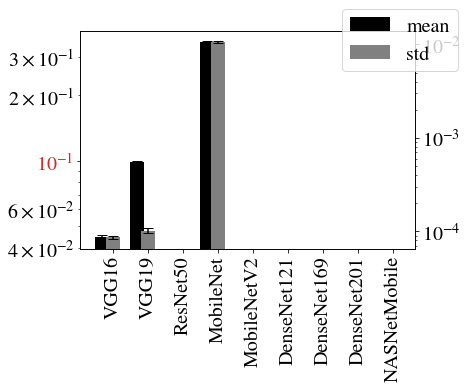

In [23]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

eps = 0.3
xs = np.arange(len(models))
ax1.bar(xs, m_means, width = 0.4, tick_label = model_names, yerr = s_means,
        error_kw = {'capsize': 5}, color = 'black', label = 'mean')
ax2.bar(xs + eps, m_stds, width = 0.4, tick_label = model_names, yerr = s_stds,
        error_kw = {'capsize': 5}, color = 'gray', label = 'std')
ax1.tick_params(axis = 'x', rotation=90)
ax1.set_yscale('log')
ax2.set_yscale('log')
plt.figlegend()
#plt.bar([1 + 0.5,2 + 0.5,3 + 0.5], [4,5,6], width = 0.4)

Why same as input-only?

In [24]:
# counting number of parameters and number of layers
params = []
layers = []

# loop over models
for i, mm in zip(range(len(models)), m_means):
    # number of parameters or 0
    c_params, c_layers = 0, 0
    
    # mean > 0 (equiv: no branches)
    if mm > 0:
        # clearing memory
        K.clear_session()
        
        # obtaining model
        m = get_model(i)
        
        # counting parameters
        c_params = m.count_params()
        c_layers = len(m.layers)
    
    
    params += [c_params]
    layers += [c_layers]

# repeating multiple times
pickle_w([params, layers], 'ConvNetTest-ft-3')

In [25]:
[params, layers] = pickle_r('ConvNetTest-ft-3')

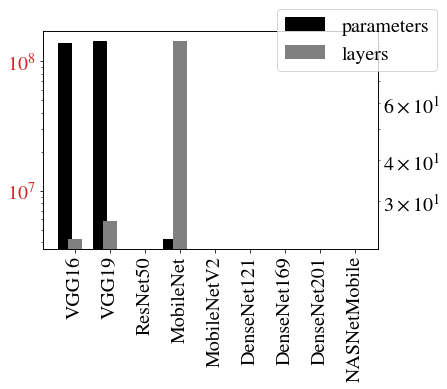

In [26]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

eps = 0.3
xs = np.arange(len(models))
ax1.bar(xs, params, width = 0.4, tick_label = model_names, color = 'black', label = 'parameters')
ax2.bar(xs + eps, layers, width = 0.4, tick_label = model_names, color = 'gray', label = 'layers')
ax1.tick_params(axis = 'x', rotation=90)
ax1.set_yscale('log')
ax2.set_yscale('log')
plt.figlegend()
#plt.bar([1 + 0.5,2 + 0.5,3 + 0.5], [4,5,6], width = 0.4)

/localhome/volodin/miniconda3/envs/rl/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


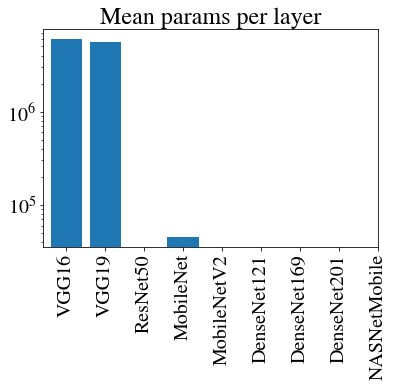

In [27]:
plt.title('Mean params per layer')
mean_param = np.array(params) / layers
plt.bar(xs, mean_param, tick_label = model_names)
plt.tick_params(axis = 'x', rotation=90)
plt.yscale('log')
plt.show()

In [76]:
xs = np.array(m_stds) ** 2
ys = mean_param ** 0.5
idx = np.where(ys > 0)[0]
xs = xs[idx]
ys = ys[idx]
xs = np.log(xs)
ys = np.log(ys)
print(xs, ys)

[-18.71411315 -18.39484308  -9.07723263] [7.80492879 7.76245691 5.36536941]


/localhome/volodin/miniconda3/envs/rl/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


In [77]:
C = curve_fit(line_1_bias, xs, ys)[0]

Text(0, 0.5, '$\\sim \\log n$\nslope=-0.26')

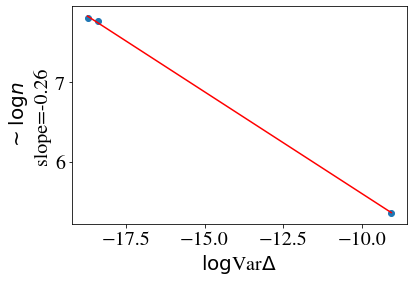

In [78]:
plt.scatter(xs, ys)
z = np.logspace(-10, -2, 10)
plt.plot(xs, line_1_bias(xs, *C), color = 'red')
plt.xlabel('$\log$Var$\Delta$')
plt.ylabel('$\sim \log n$\nslope=%.2f' % C[1])
#plt.ticklabel_format(style='sci', axis='x', scilimits=(9,-9))

The data is explained by the theory: the more layer is wide, the better is fault tolerance (no single point of failure)

#### TODO: run it for the whole imagenet/random subset

The notebook does not consider bounds at all, it's purely experimental. So Taylor issues are not relevant here